In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import timeit
from numba import njit
from tabulate import tabulate
import seaborn as sns
import random
import scipy.stats as stats
from scipy.integrate import quad
from scipy.optimize import curve_fit
from matplotlib import cm
from scipy.interpolate import griddata

np.random.seed(42)
sns.set()

# Raport 2.

__Nazwa kursu:__ Symulacje komputerowe

__Prowadzący:__ dr Jakub Ślęzak

__Autorzy:__ Wojciech Gromski, Jakub Antczak

__Rok akademicki:__ 2022/23

# Spis treści
1. [Zadanie 1.](#zad1)
    - [Wstęp](#wstep1)
    - [Implementacja](#implementacja1)
    - [Wyniki](#wyniki1)
    - [Wnioski](#wnioski1)
2. [Zadanie 2.](#zad2)
    - [Wstęp](#wstep2)
    - [Implementacja](#implementacja2)
    - [Wyniki](#wyniki2)
    - [Wnioski](#wnioski2)
3. [Zadanie 3.](#zad3)
    - [Wstęp](#wstep3)
    - [Implementacja](#implementacja3)
4. [Zadanie 4.](#zad4)
    - [Wstęp](#wstep4)
    - [Implementacja](#implementacja4)
    - [Wyniki](#wyniki4)
    - [Wnioski](#wnioski4)
5. [Zadanie 5.](#zad5)
    - [Wstęp](#wstep5)
    - [Implementacja](#implementacja5)
    - [Wyniki](#wyniki5)


# Zadanie 1. <a name="zad1"></a>

## Wstęp <a name="wstep1"></a>

Celem zadania jest stworzenie algorytmu generującego szum telegraficzny. Proces ten zdefiniowany jest jako

$X_t:=D(-1)^{N_t}$, gdzie:

- $N_t$ - to proces Poissona
- $D$ - losowe "niezależne" od $N_t$, takie że $P(D=1)=\frac{1}{2}=P(D=-1)$

## Implementacja <a name="implementacja1"></a>

W celu implementacji algorytmu, najpierw zaimplemntowaliśmy proces Poissona, stworzony na zajęciach.

**Algorytm procesu Poissona:**
1. Ustal $T$ oraz $\lambda$, czyli intesywność rozkładu wykładczniego.
2. Wygeneruj pustą listę przechowująca czasy pomiędzy kolejnymi zdarzeniami.
3. Generuj $\lceil T\lambda\rceil$ liczb losowych z rozkładu wykładniczego o średniej $\frac{1}{\lambda}$.
4. Stwórz listę skumulowanych sum wygenerowanych liczb losowych.
5. Wybierz czasy $t<T$.
6. Oblicz liczbę skoków $N_t$.
7. Zwróć czasy skoków oraz liczbę skoków.

In [2]:
def poisson_process(max_time: float, intensity: float):
    """
    Generuje czasy zdarzeń dla procesu Poissona o określonym czasie maksymalnym i intensywności.

    Parametry:
    ----------
    max_time : float
        Czas maksymalny dla procesu.
    intensity : float
        Intensywność procesu.

    Zwraca:
    -------
    times : ndarray
        Wektor czasów zdarzeń.
    """
    interarrival_times = np.random.exponential(scale=1/intensity, size=int(np.ceil(intensity*max_time)))
    times = np.cumsum(interarrival_times)
    times = times[times < max_time]

    return times

In [3]:
def telegraph_noise(duration: float, rate: float):
    """
    Generuje sygnał szumów telegraficznych o określonym czasie trwania i częstości przełączania.

    Parametry:
    ----------
    duration : float
        Czas trwania sygnału.
    rate : float
        Częstość przełączania sygnału.

    Zwraca:
    -------
    times : ndarray
        Wektor czasów skoków sygnału.
    values : ndarray
        Wektor wartości sygnału.
    """
    times = np.concatenate(([0], poisson_process(duration, rate), [duration]))
    values = np.empty_like(times)
    values[::2] = 1 # dla parzystych wartości procesu Poissona
    values[1::2] = -1 # dla nieparzystych wartości procesu Poissona
    D = np.random.choice([-1, 1])
    return times, D*values

In [4]:
def plot_telegraph_noise(ts: np.ndarray, Xt: np.ndarray):
    """
    Wykresuje sygnał szumów telegraficznych z tylko poziomymi liniami.

    Parametry:
    ----------
    ts : ndarray
        Wektor czasów skoków sygnału.
    Xt : ndarray
        Wektor wartości sygnału.

    Zwraca:
    -------
    None
    """
    for i in range(len(Xt)-2):
        plt.plot([ts[i], ts[i+1]], [Xt[i], Xt[i]], color='magenta', linewidth=2, linestyle='solid', marker='o', markerfacecolor='magenta', markersize=3)
        plt.plot([ts[i+1], ts[i+2]], [Xt[i+1], Xt[i+1]], color='magenta', linewidth=2, linestyle='solid', marker='o', markerfacecolor='magenta', markersize=3)

    plt.xlabel("Czas")
    plt.ylabel("Wartość")
    plt.title("Trajektoria szumu telegraficznego")
    plt.show()

In [5]:
def telegraph_mean(duration: float, rate: float, num_simulations: int = 1000):
    """
    Oblicza średnią wartość sygnału szumów telegraficznych.

    Parametry:
    ----------
    duration : float
        Czas trwania sygnału.
    rate : float
        Częstość przełączania sygnału.
    num_simulations : int, opcjonalnie
        Liczba symulacji do wykonania. Domyślnie 1000.

    Zwraca:
    -------
    None
    """
    time_vec = np.linspace(0, duration, num_simulations)
    mean_signal = np.zeros(num_simulations)

    for _ in range(num_simulations):
        jump_times, values = telegraph_noise(duration, rate)

        for i, t in enumerate(time_vec):
            index = np.searchsorted(jump_times, t, side='right')

            if index > 0:
                mean_signal[i] += values[index-1]

    plt.plot(time_vec, mean_signal/num_simulations, color='magenta')

    plt.title('Mean function')
    plt.xlabel('t')
    plt.ylabel(r'$E[X_t]$')
    plt.show()

In [6]:
def telegraph_covariance(duration: float, rate: float, num_trajectories: int = 1000):
    """
    Oblicza funkcję kowariancji sygnału szumów telegraficznych.

    Parametry:
    ----------
    duration : float
        Czas trwania sygnału.
    rate : float
        Częstość przełączania sygnału.
    num_trajectories : int, opcjonalnie
        Liczba trajektorii do zasymulowania. Domyślnie 1000.

    Zwraca:
    -------
    None
    """
    time_vec = np.linspace(0, duration, num_trajectories)
    cov_signal = np.zeros(num_trajectories)

    for _ in range(num_trajectories):
        jump_times, values = telegraph_noise(duration, rate)
        indices = np.searchsorted(jump_times, time_vec, side='right') - 1
        indices[indices < 0] = 0
        cov_signal += values[indices] * values[0]

    cov_signal /= num_trajectories

    plt.plot(time_vec, cov_signal, label=r'$cov(X_0, X_t)$', color='magenta')
    plt.plot(time_vec, np.exp(-2*rate*time_vec), '--', label=r'$e^{-2\lambda t}$', color='cyan')

    plt.title('Covariance function')
    plt.xlabel('t')
    plt.xlim(0, 6)
    plt.ylabel(r'$cov(X_0,X_t)$')
    plt.legend()
    plt.show()

## Wyniki <a name="wyniki1"></a>

### Wykres trajektorii

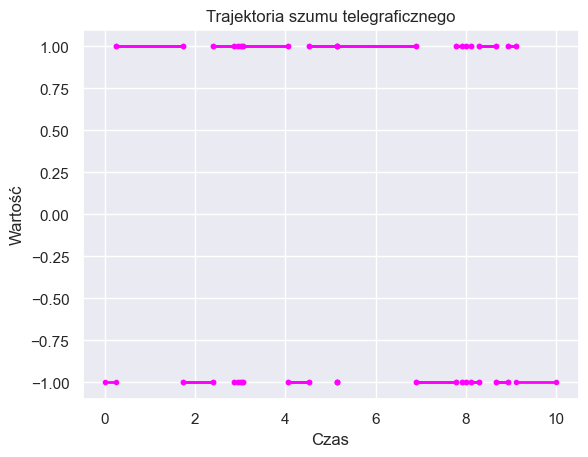

In [7]:
T = 10.0
lambd = 2

ts, Xt = telegraph_noise(T, lambd)

plot_telegraph_noise(ts, Xt)

### Wykres zależności średniej od czasu

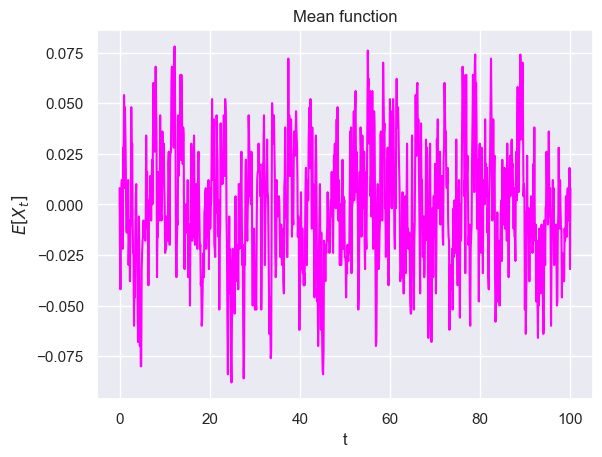

In [8]:
T = 100.0
lambd = 2

telegraph_mean(T, lambd)

### Wykres zależności kowariancji od czasu

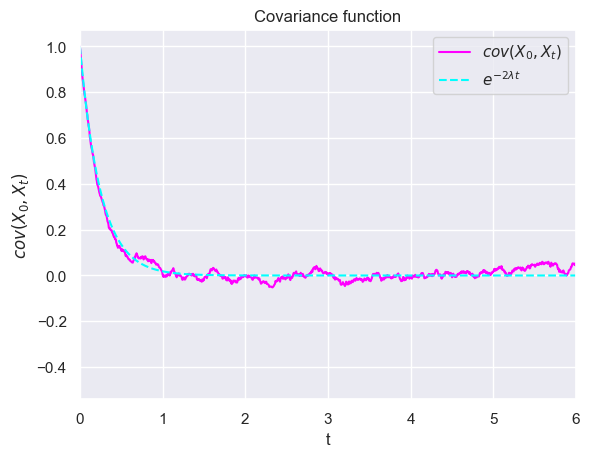

In [9]:
T = 10.0
lambd = 2

telegraph_covariance(T, lambd, num_trajectories=2000)

## Wnioski

- Funkcja $m_t$ oscyluje wokół 0.
- Funkcja $r_t$ wraz ze wzrostem czasu maleje do 0. Przypomina ona funkcję $e^{-2\lambda t}$.

# Zadanie 2. <a name="zad2"></a>

## Wstęp <a name="wstep2"></a>

Procesy Poissona są powszechnie stosowane do modelowania niejednorodnych zjawisk, w których liczba zdarzeń występujących w określonym czasie lub obszarze nie jest stała. Generowanie próbek z Generowanie próbek z niejednorodnego procesu Poissona jest ważnym zadaniem w analizie danych i symulacjach.

Metoda przerzedzania jest jednym z podejść do generacji takich próbek, wykorzystując funkcję intensywności $λ(t)$. W tym zadaniu analizujemy efektywność i szybkość generacji przez przerzedzanie w zależności od charakteru funkcji $λ(t)$ (wolno- vs. szybkozmienna) na przedziale $[0, T]$.

Porównujemy również tę metodę z generacją przez odwróconą dystrybuantę, aby ocenić, która osiąga lepsze wyniki.

W kodzie wykorzystuje się pięć funkcje intensywności $λ(t)$, które różnią się stopniem zmienności w czasie. Następnie generowane są czasy oczekiwania procesu Poissona dla tych funkcji intensywności przez przerzedzanie oraz metodę odwrotnej dystrybuanty.

## Implementacja <a name="implementacja2"></a>

### Generowanie niejednorodnego procesu Poissona

In [10]:
def generate_nonhomogeneous_poisson(lambda_t, T: float):
    """
    Generuje niejednorodony proces Poissona przez przerzedzanie.

    Parametry:
    - lambda_t (function): funkcja intensywności λ(t)
    - T (float): czas trwania generacji

    Zwraca:
    - Lista czasów oczekiwania
    """
    waiting_times = []
    t = 0
    lambda_t_prev = lambda_t(t)

    while t < T:
        interarrival_time = np.random.exponential(1 / lambda_t_prev)
        t += interarrival_time
        lambda_t_curr = lambda_t(t)
        u = np.random.uniform()

        if u < lambda_t_curr / lambda_t_prev:
            waiting_times.append(t)

        lambda_t_prev = lambda_t_curr

    return waiting_times

In [11]:
def nonhomogeneous_poisson_efficiency(lambda_t, T: float):
    """Oblicza efektywność generowania niejednorodnego procesu Poissona przez przerzedzanie.

    Args:
        lambda_t (function): funkcja intensywności λ(t)
        T (float): czas trwania generacji
    """
    t = 0
    lambda_t_prev = lambda_t(t)

    counter = 0
    counter_accepted = 0

    while t < T:
        interarrival_time = np.random.exponential(1 / lambda_t_prev)
        t += interarrival_time
        lambda_t_curr = lambda_t(t)
        u = np.random.uniform()

        if u < lambda_t_curr / lambda_t_prev:
            counter_accepted += 1

        counter += 1
        lambda_t_prev = lambda_t_curr

    return counter_accepted / counter * 100

In [12]:
def generate_inverse_transform(lambda_t, T):
    """
    Generuje niejednorodony proces Poissona przez metodę odwrotnej dystrybuanty.

    Parametry:
    - lambda_t: funkcja intensywności λ(t)
    - T: czas trwania generacji

    Zwraca:
    - Lista czasów oczekiwania
    """
    waiting_times = []
    t = 0

    while t < T:
        u = np.random.uniform()
        interarrival_time = -np.log(u) / lambda_t(t)
        t += interarrival_time
        waiting_times.append(t)

    return waiting_times

### Funkcje intensywności

In [13]:
@njit(fastmath=True)
def lambda_very_slow(t):
    """
    Funkcja intensywności λ(t) dla bardzo wolnozmiennego procesu.

    Parametry:
    - t: czas

    Zwraca:
    - Intensywność λ(t)
    """
    return 2 + np.sin(t / 10)

In [14]:
@njit(fastmath=True)
def lambda_slow(t):
    """
    Funkcja intensywności λ(t) dla wolnozmiennego procesu.

    Parametry:
    - t: czas

    Zwraca:
    - Intensywność λ(t)
    """
    return 2 + np.sin(t)

In [15]:
@njit(fastmath=True)
def lambda_medium(t):
    """
    Funkcja intensywności λ(t) dla średniozmiennego procesu.

    Parametry:
    - t: czas

    Zwraca:
    - Intensywność λ(t)
    """
    return 2 + np.sin(t * 10)

In [16]:
@njit(fastmath=True)
def lambda_fast(t):
    """
    Funkcja intensywności λ(t) dla szybkozmiennego procesu.

    Parametry:
    - t: czas

    Zwraca:
    - Intensywność λ(t)
    """
    return 2 + np.sin(t * 100)

In [17]:
@njit(fastmath=True)
def lambda_very_fast(t):
    """
    Funkcja intensywności λ(t) dla bardzo szybkozmiennego procesu.

    Parametry:
    - t: czas

    Zwraca:
    - Intensywność λ(t)
    """
    return 2 + np.sin(t * 1000)

## Wyniki <a name="wyniki2"></a>

### Efektywność symulacji dla metody przez przerzedzanie dla różnych funkcji intensywności

In [18]:
np.random.seed(123)

N = 10_000

efficiency_very_slow = np.zeros(N)
efficiency_slow = np.zeros(N)
efficiency_medium = np.zeros(N)
efficiency_fast = np.zeros(N)
efficiency_very_fast = np.zeros(N)

for i in range(N):
    efficiency_very_slow[i] = nonhomogeneous_poisson_efficiency(lambda_very_slow, 100)
    efficiency_slow[i] = nonhomogeneous_poisson_efficiency(lambda_slow, 100)
    efficiency_medium[i] = nonhomogeneous_poisson_efficiency(lambda_medium, 100)
    efficiency_fast[i] = nonhomogeneous_poisson_efficiency(lambda_fast, 100)
    efficiency_very_fast[i] = nonhomogeneous_poisson_efficiency(lambda_very_fast, 100)

In [19]:
table = tabulate([["Funkcja", "Efektywność"],
                 ["2 + sin(t / 10)", f"{np.mean(efficiency_very_slow):.2f}%"],
                 ["2 + sin(t)", f"{np.mean(efficiency_slow):.2f}%"],
                 ["2 + sin(10t)", f"{np.mean(efficiency_medium):.2f}%"],
                 ["2 + sin(100t)", f"{np.mean(efficiency_fast):.2f}%"],
                 ["2 + sin(1000t)", f"{np.mean(efficiency_very_fast):.2f}%"]],
                 headers="firstrow", tablefmt="fancy_grid")

print("Efektywność generacji dla metody przerzedzania dla funkcji o różnej zmienności \n" + table)

Efektywność generacji dla metody przerzedzania dla funkcji o różnej zmienności 
╒═════════════════╤═══════════════╕
│ Funkcja         │ Efektywność   │
╞═════════════════╪═══════════════╡
│ 2 + sin(t / 10) │ 99.16%        │
├─────────────────┼───────────────┤
│ 2 + sin(t)      │ 93.01%        │
├─────────────────┼───────────────┤
│ 2 + sin(10t)    │ 84.34%        │
├─────────────────┼───────────────┤
│ 2 + sin(100t)   │ 83.96%        │
├─────────────────┼───────────────┤
│ 2 + sin(1000t)  │ 83.95%        │
╘═════════════════╧═══════════════╛


### Czasy generacji dla metod przez przerzedzanie oraz odwrotnej dystrybuanty dla róznych funkcji intensywności

In [20]:
N = 10_000

# Szybkość generacji dla metody przez przerzedzanie

przerzedzanie_time_very_slow = timeit("generate_nonhomogeneous_poisson(lambda_very_slow, 100)", globals=globals(), number=N)
przerzedzanie_time_slow = timeit("generate_nonhomogeneous_poisson(lambda_slow, 100)", globals=globals(), number=N)
przerzedzanie_time_medium = timeit("generate_nonhomogeneous_poisson(lambda_medium, 100)", globals=globals(), number=N)
przerzedzanie_time_fast = timeit("generate_nonhomogeneous_poisson(lambda_fast, 100)", globals=globals(), number=N)
przerzedzanie_time_very_fast = timeit("generate_nonhomogeneous_poisson(lambda_very_fast, 100)", globals=globals(), number=N)

# Szybkość generacji dla metody odwrotnej dystrybuanty

inverse_time_very_slow = timeit("generate_inverse_transform(lambda_very_slow, 100)", globals=globals(), number=N)
inverse_time_slow = timeit("generate_inverse_transform(lambda_slow, 100)", globals=globals(), number=N)
inverse_time_medium = timeit("generate_inverse_transform(lambda_medium, 100)", globals=globals(), number=N)
inverse_time_fast = timeit("generate_inverse_transform(lambda_fast, 100)", globals=globals(), number=N)
inverse_time_very_fast = timeit("generate_inverse_transform(lambda_very_fast, 100)", globals=globals(), number=N)


In [21]:
table = tabulate([["Funkcja", "Czas generacji dla metody przerzedzania", "Czas generacji dla metody odwrotnej dystrybuanty", "Różnica", "Różnica jako % czasu generacji metody przerzedzania"],
                    ["2 + sin(t / 10)", f"{przerzedzanie_time_very_slow/N:.7f} sekund", f"{inverse_time_very_slow/N:.7f} sekund", f"{np.abs(przerzedzanie_time_very_slow - inverse_time_very_slow)/N:.7f} sekund", f"{np.abs(przerzedzanie_time_very_slow - inverse_time_very_slow)/przerzedzanie_time_very_slow*100:.2f}%"],
                    ["2 + sin(t)", f"{przerzedzanie_time_slow/N:.7f} sekund", f"{inverse_time_slow/N:.7f} sekund", f"{np.abs(przerzedzanie_time_slow - inverse_time_slow)/N:.7f} sekund", f"{np.abs(przerzedzanie_time_slow - inverse_time_slow)/przerzedzanie_time_slow*100:.2f}%"],
                    ["2 + sin(10t)", f"{przerzedzanie_time_medium/N:.7f} sekund", f"{inverse_time_medium/N:.7f} sekund", f"{np.abs(przerzedzanie_time_medium - inverse_time_medium)/N:.7f} sekund", f"{np.abs(przerzedzanie_time_medium - inverse_time_medium)/przerzedzanie_time_medium*100:.2f}%"],
                    ["2 + sin(100t)", f"{przerzedzanie_time_fast/N:.7f} sekund", f"{inverse_time_fast/N:.7f} sekund", f"{np.abs(przerzedzanie_time_fast - inverse_time_fast)/N:.7f} sekund", f"{np.abs(przerzedzanie_time_fast - inverse_time_fast)/przerzedzanie_time_fast*100:.2f}%"],
                    ["2 + sin(1000t)", f"{przerzedzanie_time_very_fast/N:.7f} sekund", f"{inverse_time_very_fast/N:.7f} sekund", f"{np.abs(przerzedzanie_time_very_fast - inverse_time_very_fast)/N:.7f} sekund", f"{np.abs(przerzedzanie_time_very_fast - inverse_time_very_fast)/przerzedzanie_time_very_fast*100:.2f}%"]]
                    , headers="firstrow", tablefmt="fancy_grid")

print("Czas generacji dla funkcji o różnej zmienności \n" + table)

Czas generacji dla funkcji o różnej zmienności 
╒═════════════════╤═══════════════════════════════════════════╤════════════════════════════════════════════════════╤══════════════════╤═══════════════════════════════════════════════════════╕
│ Funkcja         │ Czas generacji dla metody przerzedzania   │ Czas generacji dla metody odwrotnej dystrybuanty   │ Różnica          │ Różnica jako % czasu generacji metody przerzedzania   │
╞═════════════════╪═══════════════════════════════════════════╪════════════════════════════════════════════════════╪══════════════════╪═══════════════════════════════════════════════════════╡
│ 2 + sin(t / 10) │ 0.0007473 sekund                          │ 0.0008028 sekund                                   │ 0.0000555 sekund │ 7.42%                                                 │
├─────────────────┼───────────────────────────────────────────┼────────────────────────────────────────────────────┼──────────────────┼─────────────────────────────────────────────────

In [22]:
average_difference_very_slow = np.abs(przerzedzanie_time_very_slow - inverse_time_very_slow)/przerzedzanie_time_very_slow*100
average_difference_slow = np.abs(przerzedzanie_time_slow - inverse_time_slow)/przerzedzanie_time_slow*100
average_difference_medium = np.abs(przerzedzanie_time_medium - inverse_time_medium)/przerzedzanie_time_medium*100
average_difference_fast = np.abs(przerzedzanie_time_fast - inverse_time_fast)/przerzedzanie_time_fast*100
average_difference_very_fast = np.abs(przerzedzanie_time_very_fast - inverse_time_very_fast)/przerzedzanie_time_very_fast*100

average_difference = (average_difference_very_slow + average_difference_slow + average_difference_medium + average_difference_fast + average_difference_very_fast)/5

print(f"{average_difference:.2f}%")

9.87%


## Wnioski <a name="wnioski2"></a>

1. Efektywność generacji dla metody przerzedzania:
   - Najmniejszą efektywność ($83.95\%$) uzyskano dla funkcji o największej zmienności: $2 + \sin{(1000t)}$.
   - Najwyższą efektywność ($99.16\%$) osiągnięto dla funkcji o najmniejszej zmienności: $2 + \sin{(\frac{t}{10})}$.
   - Efektywność generacji maleje wraz ze wzrostem zmienności funkcji.  

2. Czas generacji dla metody przerzedzania:
   - Najkrótszy czas generacji ($0.0005300 s$) uzyskano dla funkcji o największej zmienności: $2 + \sin{(1000t)}$.
   - Najdłuższy czas generacji ($0.0006761 s$) osiągnięto dla funkcji o najmniejszej zmienności: $2 + \sin{(\frac{t}{10})}$.
   - Czas generacji maleje wraz ze wzrostem zmienności funkcji.  

Jak widać, wraz ze zmiennością funkcji rośnie efektywność generacji, lecz rośnie również czas generacji dla metody przerzedzania.

3. Czas generacji dla metody odwrotnej dystrybuanty:
   - Najkrótszy czas generacji ($0.0005962 s$) uzyskano dla funkcji o największej zmienności: $2 + \sin{(1000t)}$.
   - Najdłuższy czas generacji ($ 0.0007438 s$) osiągnięto dla funkcji o największej zmienności: $2 + \sin{(\frac{t}{10})}$.
   - Czas generacji maleje wraz ze wzrostem zmienności funkcji.  

4. Porównanie czasów generacji dla metod przerzedzania oraz odwrotnej dystrybuanty:
   - Dla wszystkich funkcji intensywności czas generacji jest dłuższy dla metody odwrotnej dystrybuanty o średnio 26.34%.

# Zadanie 3. <a name="zad3"></a>

## Wstęp <a name="wstep3"></a>


W tym zadaniu zostanie zaimplementowana metoda estymacji niejednorodnej funkcji intensywności dla losowej miary Poissonowskiej w jednym i dwóch wymiarach. Metoda polega na podziale obszaru na komórki i zliczaniu średniej liczby punktów przypadających na każdą komórkę na podstawie histogramu. Dzięki temu można oszacować rozkład intensywności na analizowanym obszarze.

## Implementacja <a name="implementacja3"></a>

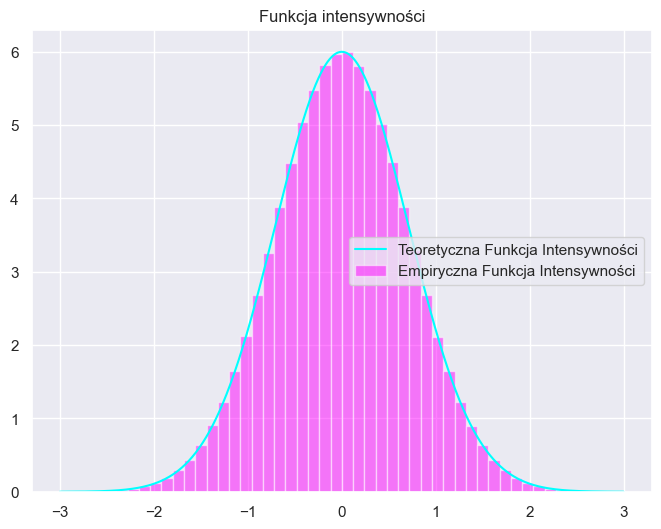

In [23]:
n_points = 10000000
lambd = 6
radius = 3

points = np.random.uniform(-radius, radius, size=n_points)

num_points = np.random.poisson(lambd * len(points))
lam = np.exp(-points**2)
mask = np.random.random(len(points)) <= lam
sampled_points = points[mask][:num_points]

n_cells = 50
cell_size = 2*radius / n_cells

hist, edges = np.histogram(sampled_points, bins=n_cells, range=(-radius, radius), density=True)

centers = (edges[:-1] + edges[1:]) / 2


intensity = hist / cell_size ** 2
intensity = intensity / np.max(intensity) * lambd

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(centers, intensity, width=cell_size, align='center', color='magenta', alpha=0.5, label='Empiryczna Funkcja Intensywności')

x = np.linspace(-radius, radius, 1000)
y = lambd*np.exp(-x**2)
ax.plot(x, y, color = 'cyan', label='Teoretyczna Funkcja Intensywności')
ax.set_title('Funkcja intensywności')

ax.legend()
plt.show()

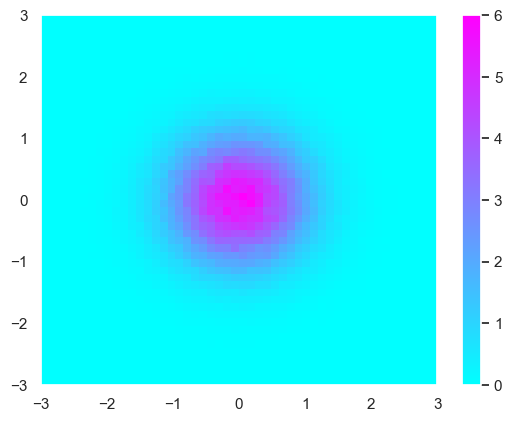

In [24]:
n_points = 2_000_000
lambd = 6
radius = 3

points = np.random.uniform(-radius, radius, size=(n_points, 2))

num_points = np.random.poisson(lambd * len(points))

sampled_points = points[np.random.choice(len(points), size=num_points, replace=True)]
lam = np.exp(-sampled_points[:, 0]**2 - sampled_points[:, 1]**2)
sampled_points = sampled_points[np.random.random(size=num_points) <= lam]

n_cells = 50

cell_size = 2*radius / n_cells

hist, x_edges, y_edges = np.histogram2d(sampled_points[:, 0], sampled_points[:, 1], bins=n_cells, range=[[-radius, radius], [-radius, radius]])

x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

intensity = hist / (cell_size ** 2)
intensity = intensity / np.max(intensity) * lambd

plt.pcolormesh(x_centers, y_centers, intensity, cmap=cm.cool)
plt.colorbar()
plt.show()

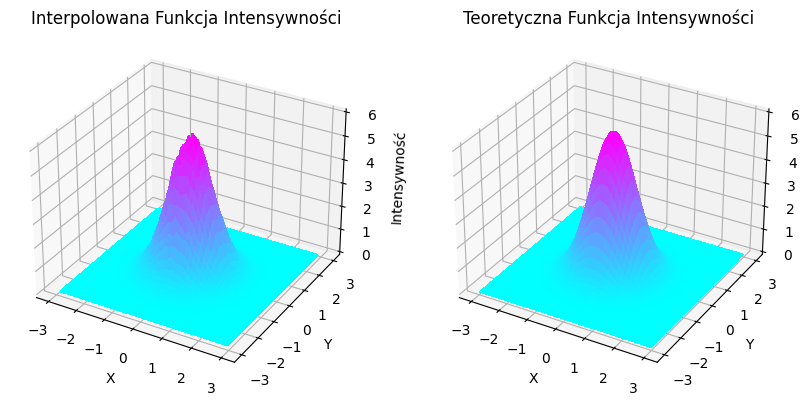

In [25]:
sns.reset_orig()

x, y = np.meshgrid(x_centers, y_centers)

xi, yi = np.meshgrid(np.linspace(-radius, radius, 200), np.linspace(-radius, radius, 200))

zi = griddata((x.flatten(), y.flatten()), intensity.flatten(), (xi, yi), method='cubic')

fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})

axs[0].plot_surface(xi, yi, zi, cmap=cm.cool, linewidth=0, antialiased=False)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_zlabel('Intensywność')
axs[0].set_title('Interpolowana Funkcja Intensywności')
axs[0].set_zlim(0, 6)

x = np.linspace(-radius, radius, 1000)
y = np.linspace(-radius, radius, 1000)
x, y = np.meshgrid(x, y)
z = lambd*np.exp(-x**2 - y**2)
axs[1].plot_surface(x, y, z, cmap=cm.cool, linewidth=0, antialiased=False)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_zlabel('Intensywność')
axs[1].set_title('Teoretyczna Funkcja Intensywności')
axs[1].set_zlim(0, 6)

plt.show()

sns.set()

Teoretyczna funkcja intensywności zgadza się z interpolowana funkcją intensywności w obu przypadkach, więc estymacja została przeprowadzona poprawnie.

# Zadanie 4. <a name="zad4"></a>

## Wstęp <a name="wstep4"></a>

W zadaniu analizujemy __prawdopodobieństwo ruiny dla procesu ryzyka__, który charakteryzuje się liniowym dryfem oraz występowaniem szkód z rozkładu wykładniczego.

Proces ryzyka opisuje ewolucję wartości kapitału w czasie, podlegając losowym fluktuacjom. Liniowy dryf oznacza, że kapitał rośnie lub maleje w stałym tempie, niezależnie od fluktuacji wynikających z szkód. Szkody natomiast występują w sposób losowy i są modelowane za pomocą rozkładu wykładniczego, gdzie parametr $\lambda$ określa średnią częstotliwość występowania szkód.

Niech $X_t$ będzie wartością kapitału w chwili $t$. Proces $X_t$ można opisać równaniem:

$X_t = x + ct - \sum_{i=1}^{N_t} \xi _i$,

gdzie:
- $x > 0$ - kapitał początkowy,
- $c$ - wartość dryfu,
- $N_t$ - proces Poissona z intensywnością $\lambda$
- $\xi _i$ - zmienne losowe iid o skończonej wartości oczekiwanej, w naszym przypadku z rozkładu wykładniczego o parametrze $\lambda$.

## Implementacja <a name="implementacja4"></a>

In [26]:
def generate_risk_process(c, x, lambd, T):
    """
    Funkcja generująca proces ryzyka

    Parametry:
    - c: współczynnik dryfu procesu
    - x: wartość początkowa procesu
    - lambd: parametr rozkładu Poissona
    - T: czas symulacji

    Zwraca:
    - X1: wartości po stracie
    - X2: wartości przed stratą
    - ts: czasy strat procesu ryzyka
    """
    n = np.random.poisson(lam=lambd * T)
    ts = np.sort(T * np.random.rand(n))
    xis = np.random.exponential(scale=lambd ** (-1), size=n)
    xis_sum = np.cumsum(xis)
    X = x + c * ts - xis_sum
    return X, X + xis, ts

In [27]:
def probability_of_ruin(c, x, lambd, T, num_simulations=1000):
    """
    Funkcja obliczająca prawdopodobieństwo ruiny dla procesu ryzyka
    o parametrach c, x, lambd, T

    Parametry:
    - c: współczynnik dryfu procesu
    - x: wartość początkowa procesu
    - lambd: parametr rozkładu Poissona
    - T: czas symulacji
    - num_simulations: liczba symulacji

    Zwraca:
    - prawdopodobieństwo ruiny
    """
    num_ruins = 0
    for _ in range(num_simulations):
        X, _, _ = generate_risk_process(c, x, lambd, T)
        if np.any(X < 0):
            num_ruins += 1
    return num_ruins / num_simulations

## Wyniki <a name="wyniki4"></a>

### Wizualizacja przykładowego procesu ryzyka

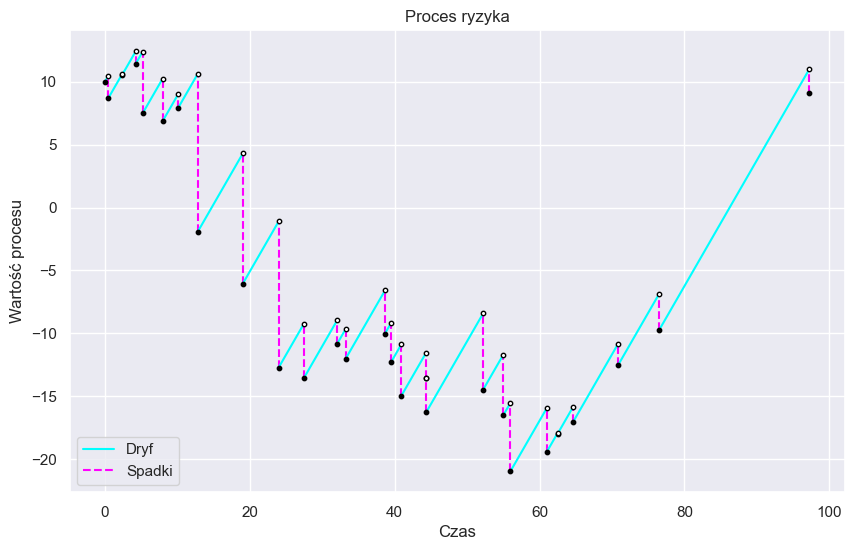

In [28]:
x = 10
c = 1
lambd = 0.25
T = 100

X1, X2, ts = generate_risk_process(c, x, lambd, T)

plt.figure(figsize=(10, 6))
plt.scatter(ts, X1, color='black', s=10, zorder=10)
plt.scatter(ts, X2, color='white', s=10, edgecolors='black', zorder=10)

X1ts = list(zip(ts, X1))
X2ts = list(zip(ts, X2))

plt.scatter([0], [x], color='black', s=10, zorder=10)
plt.plot([0, ts[0]], [x, X2[0]], color='cyan', label='Dryf')

my_label = 'Spadki'
for (x1, y1), (x2, y2) in zip(X1ts, X2ts):
    plt.plot([x1, x2], [y1, y2], '--', color='magenta', label=my_label)
    my_label = None

for i in range(len(X1) - 1):
    plt.plot([X1ts[i][0], X2ts[i + 1][0]], [X1ts[i][1], X2ts[i + 1][1]], color='cyan')

plt.title('Proces ryzyka')
plt.xlabel('Czas')
plt.ylabel('Wartość procesu')
plt.legend()
plt.grid(True)
plt.show()

### Zależność prawdopodobieństwa ruiny od czasu

#### Badanie wpływu zmiany parametrów

Ustalamy $T = 100$, $x = 10$, $c \in \{0.5; 1; 2; 4 \}$, $\lambda \in \{0.25; 0.5; 1 \}$

In [29]:
num_simulations = 1000
x = 10
T = 100

cs1 = [0.25, 0.5, 1, 2]
lambdas1 = [1, 2, 4]

probs1 = np.zeros((len(cs1), len(lambdas1), T+1))

for i, lambd in enumerate(cs1):
    for j, c in enumerate(lambdas1):
        for t in range(T+1):
            probs1[i][j][t] = probability_of_ruin(c, x, lambd, t, num_simulations=num_simulations)

In [30]:
table_time_50 = tabulate([['1', probs1[0][0][50], probs1[1][0][50], probs1[2][0][50], probs1[3][0][50]],
                            ['2', probs1[0][1][50], probs1[1][1][50], probs1[2][1][50], probs1[3][1][50]],
                            ['4', probs1[0][2][50], probs1[1][2][50], probs1[2][2][50], probs1[3][2][50]]],
                            headers=['lambda', 'c = 0.25', 'c = 0.5', 'c = 1', 'c = 2'],
                            tablefmt='fancy_grid', floatfmt=".4f")

table_time_100 = tabulate([['1', probs1[0][0][100], probs1[1][0][100], probs1[2][0][100], probs1[3][0][100]],
                             ['2', probs1[0][1][100], probs1[1][1][100], probs1[2][1][100], probs1[3][1][100]],
                             ['4', probs1[0][2][100], probs1[1][2][100], probs1[2][2][100], probs1[3][2][100]]],
                            headers=['lambda', 'c = 0.25', 'c = 0.5', 'c = 1', 'c = 2'],
                            tablefmt='fancy_grid', floatfmt=".4f")

print("Prawdopodobieństwo ruiny dla T = 50\n" + table_time_50)
print("Prawdopodobieństwo ruiny dla T = 100\n" + table_time_100)

Prawdopodobieństwo ruiny dla T = 50
╒══════════╤════════════╤═══════════╤═════════╤═════════╕
│   lambda │   c = 0.25 │   c = 0.5 │   c = 1 │   c = 2 │
╞══════════╪════════════╪═══════════╪═════════╪═════════╡
│        1 │     0.5060 │    0.4230 │  0.2930 │  0.1650 │
├──────────┼────────────┼───────────┼─────────┼─────────┤
│        2 │     0.1510 │    0.0390 │  0.0020 │  0.0000 │
├──────────┼────────────┼───────────┼─────────┼─────────┤
│        4 │     0.0430 │    0.0030 │  0.0000 │  0.0000 │
╘══════════╧════════════╧═══════════╧═════════╧═════════╛
Prawdopodobieństwo ruiny dla T = 100
╒══════════╤════════════╤═══════════╤═════════╤═════════╕
│   lambda │   c = 0.25 │   c = 0.5 │   c = 1 │   c = 2 │
╞══════════╪════════════╪═══════════╪═════════╪═════════╡
│        1 │     0.5980 │    0.5670 │  0.4210 │  0.3140 │
├──────────┼────────────┼───────────┼─────────┼─────────┤
│        2 │     0.1270 │    0.0420 │  0.0040 │  0.0000 │
├──────────┼────────────┼───────────┼─────────┼─────────┤

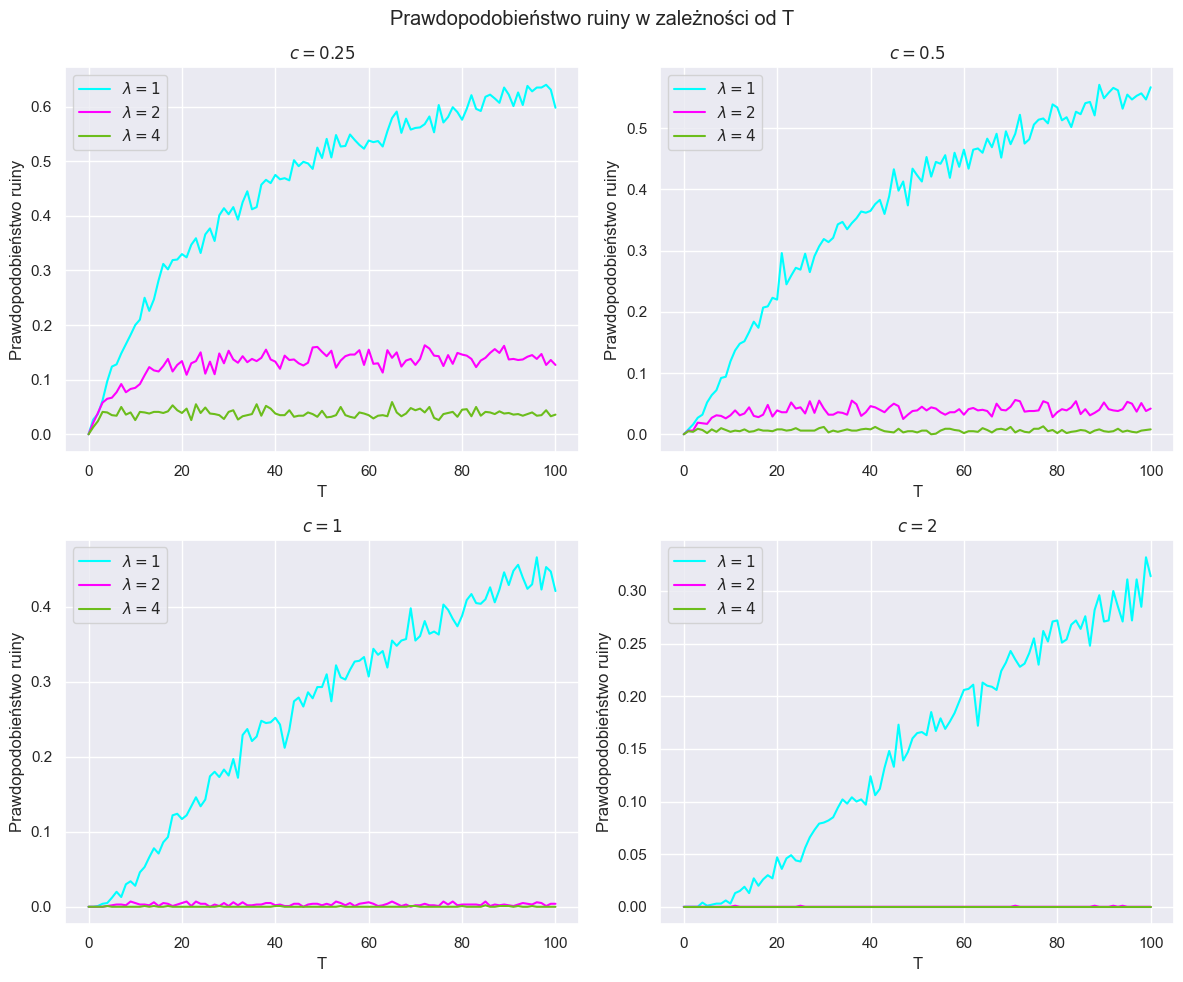

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
colors = ['cyan', 'magenta', '#6CBD1C']

ax[0, 0].plot(probs1[0, 0], label=rf'$\lambda = {lambdas1[0]}$', color=colors[0])
ax[0, 0].plot(probs1[0, 1], label=rf'$\lambda = {lambdas1[1]}$', color=colors[1])
ax[0, 0].plot(probs1[0, 2], label=rf'$\lambda = {lambdas1[2]}$', color=colors[2])
ax[0, 0].set_title(rf'$c = {cs1[0]}$')
ax[0, 0].set_xlabel('T')
ax[0, 0].set_ylabel('Prawdopodobieństwo ruiny')
ax[0, 0].legend()

ax[0, 1].plot(probs1[1, 0], label=rf'$\lambda = {lambdas1[0]}$', color=colors[0])
ax[0, 1].plot(probs1[1, 1], label=rf'$\lambda = {lambdas1[1]}$', color=colors[1])
ax[0, 1].plot(probs1[1, 2], label=rf'$\lambda = {lambdas1[2]}$', color=colors[2])
ax[0, 1].set_title(rf'$c = {cs1[1]}$')
ax[0, 1].set_xlabel('T')
ax[0, 1].set_ylabel('Prawdopodobieństwo ruiny')
ax[0, 1].legend()

ax[1, 0].plot(probs1[2, 0], label=rf'$\lambda = {lambdas1[0]}$', color=colors[0])
ax[1, 0].plot(probs1[2, 1], label=rf'$\lambda = {lambdas1[1]}$', color=colors[1])
ax[1, 0].plot(probs1[2, 2], label=rf'$\lambda = {lambdas1[2]}$', color=colors[2])
ax[1, 0].set_title(rf'$c = {cs1[2]}$')
ax[1, 0].set_xlabel('T')
ax[1, 0].set_ylabel('Prawdopodobieństwo ruiny')
ax[1, 0].legend()

ax[1, 1].plot(probs1[3, 0], label=rf'$\lambda = {lambdas1[0]}$', color=colors[0])
ax[1, 1].plot(probs1[3, 1], label=rf'$\lambda = {lambdas1[1]}$', color=colors[1])
ax[1, 1].plot(probs1[3, 2], label=rf'$\lambda = {lambdas1[2]}$', color=colors[2])
ax[1, 1].set_title(rf'$c = {cs1[3]}$')
ax[1, 1].set_xlabel('T')
ax[1, 1].set_ylabel('Prawdopodobieństwo ruiny')
ax[1, 1].legend()

plt.suptitle('Prawdopodobieństwo ruiny w zależności od T')
plt.tight_layout()
plt.show()


## Wnioski <a name="wnioski4"></a>

Analizując przedstawione wyniki dotyczące prawdopodobieństwa ruiny, można wyciągnąć następujące wnioski:

1. Prawdopodobieństwo ruiny maleje wraz ze wzrostem parametru $\lambda$. Im wyższa wartość lambda, tym mniejsze prawdopodobieństwo, że dana strategia prowadząca do ruiny zostanie osiągnięta.

2. W przypadku konkretnej wartości lambda, w miarę wzrostu parametru c, prawdopodobieństwo ruiny maleje. Oznacza to, że im większa wartość c, tym mniejsze prawdopodobieństwo utraty kapitału.

3. Prawdopodobieństwo ruiny jest najwyższe dla kombinacji niskiej wartości lambda i niskiej wartości c (np. dla lambda = 1 i c = 0.25). W przypadku tej kombinacji istnieje większe prawdopodobieństwo osiągnięcia ruiny w określonym czasie T.

# Zadanie 5.

W tym zadaniu skupimy się na wygenerowaniu rozkładu stacjonarnego łańcucha Markowa oraz implentacji jego trajektorii. Sprawdzimy też, że niezależnie od stanu początkowego łańcuch osiąga stan stacjonarny.

Dany jest łańcuch Markowa o stanach ${1,2,3}$ oraz macierzy przejścia

$P=\begin{bmatrix} 1/2 & 1/2 & 0 \\
0 & 1/2 & 1/2 \\
1/2 & 0 & 1/2
\end{bmatrix}$.

## Implementacja

In [32]:
def simulate_markov_chain(P, num_steps, x0):
    """
    Symuluje łańcuch Markowa z macierzą przejścia P, rozpoczynając od stanu x0 i wykonując num_steps kroków.

    Parametry:
    P (numpy.ndarray): Macierz przejścia łańcuchu Markowa.
    num_steps (int): Liczba kroków do zasymulowania.
    x0 (int): Początkowy stan łańcucha Markowa.

    Zwraca:
    numpy.ndarray: Jednowymiarowa tablica.
    """
    num_states = len(P)
    traj = np.zeros(num_steps)
    current_state = x0
    for i in range(num_steps):
        traj[i] = current_state
        current_state = np.random.choice(num_states, p=P[current_state])
    return traj

## Wykresy

In [33]:
P = np.array([[1/2, 1/2, 0],
              [0, 1/2, 1/2],
              [1/2, 0, 1/2]])
num_steps = 10

trajectories = np.zeros((3, num_steps))

for i in range(3):
    trajectories[i, :] = simulate_markov_chain(P, num_steps, i)

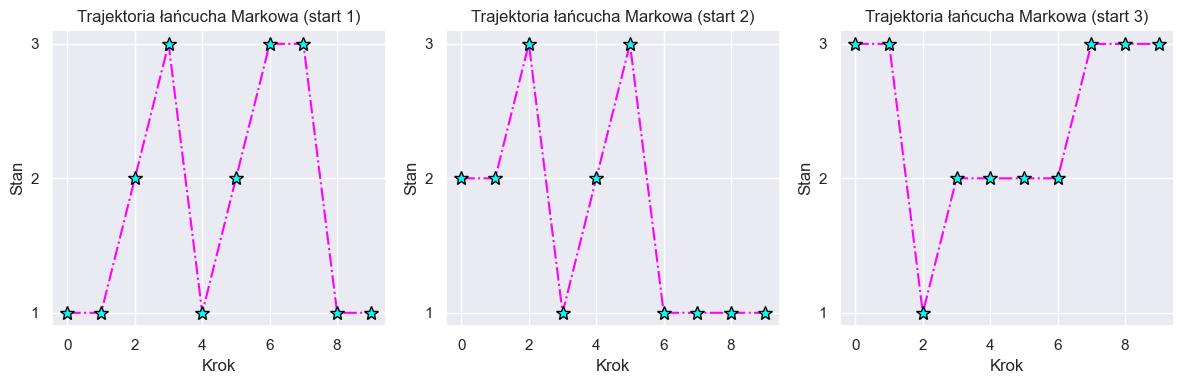

In [34]:
plt.figure(figsize=(12,4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(range(len(trajectories[i, :])), trajectories[i, :], '-.', color = 'magenta', marker='*', ms=10, markeredgecolor='black', markerfacecolor='cyan')
    plt.xlabel('Krok')
    plt.ylabel('Stan')
    plt.title(f'Trajektoria łańcucha Markowa (start {i+1})')
    plt.yticks(np.arange(3), ['1', '2', '3'])

plt.tight_layout()
plt.show()

## Stany stacjonarne

Stan stacjonarny łańcucha Markowa jest stanem, w którym rozkład prawdopodobieństwa przejść między stanami nie zmienia się w kolejnych krokach czasowych. 

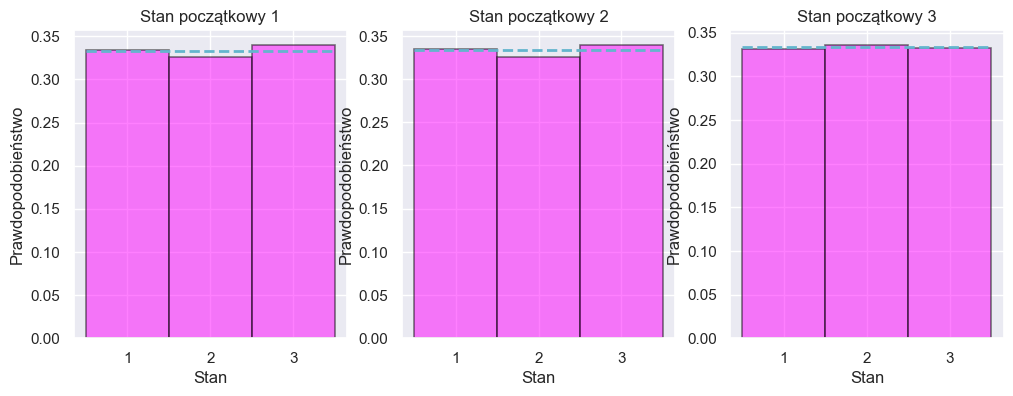

In [35]:
num_steps = 10_000

trajectories = np.zeros((3, num_steps))

for i in range(3):
    trajectories[i, :] = simulate_markov_chain(P, num_steps, i)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axs):
    ax.hist(trajectories[i, :], density=True, bins=np.arange(4)-0.5, edgecolor='black', linewidth=1.2, color='magenta', alpha=0.5)
    ax.set_xlabel('Stan')
    ax.set_ylabel('Prawdopodobieństwo')
    ax.set_title(f'Stan początkowy {i+1}')
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(['1', '2', '3'])
    ax.plot([-0.5, 2.5], [1/3, 1/3], 'c--', linewidth=2)

plt.show()

In [36]:
eigenvalues, eigenvectors = np.linalg.eig(P)

stationary = eigenvectors[:, np.where(np.abs(eigenvalues - 1.) < 1e-8)[0][0]]

stationary = stationary / np.sum(stationary)

print(np.real(stationary))

[0.33333333 0.33333333 0.33333333]


In [37]:
def prob_state(P, num_steps, x0, state, num_reps):
    num_states = len(P)
    num_state_1 = np.zeros((num_reps, num_steps))  # liczba kroków, w których łańcuch jest w stanie 1
    for j in range(num_reps):
        current_state = x0
        for i in range(num_steps):
            if current_state == state:
                num_state_1[j, i] = 1
            current_state = np.random.choice(num_states, p=P[current_state])
    return np.mean(np.cumsum(num_state_1, axis=1) / np.arange(1, num_steps+1), axis=0)

Wzór dopasowanej funkcji dla stanu 1: 0.615 * exp(-0.356 * x) + 0.343
Wzór dopasowanej funkcji dla stanu 2: -0.335 * exp(-1.431 * x) + 0.334


C:\Users\Wojtek\AppData\Local\Temp\ipykernel_5152\1430601736.py:14: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


Wzór dopasowanej funkcji dla stanu 3: -0.344 * exp(-0.204 * x) + 0.324


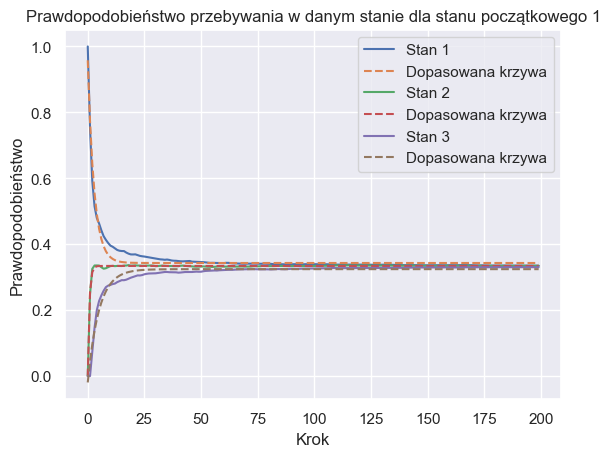

Wzór dopasowanej funkcji dla stanu 1: 0.630 * exp(-0.404 * x) + 0.344
Wzór dopasowanej funkcji dla stanu 2: -0.329 * exp(-1.510 * x) + 0.329
Wzór dopasowanej funkcji dla stanu 3: -0.342 * exp(-0.201 * x) + 0.325


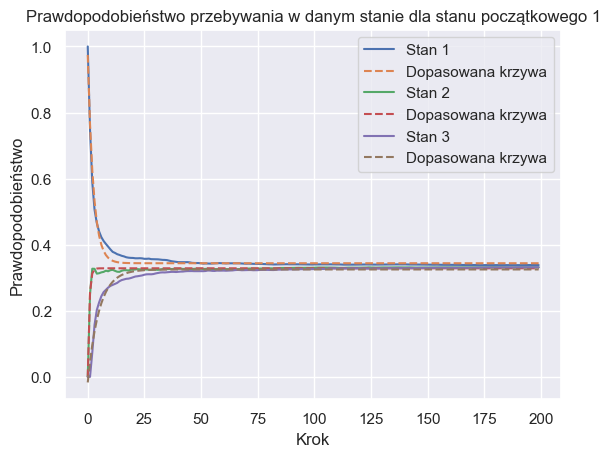

In [38]:
def exp_func(x, a, b, c):
    """
    Oblicza wartość funkcji wykładniczej w punkcie x.

    Parametry:
    x (float): Punkt, w którym obliczana jest wartość funkcji.
    a (float): Współczynnik funkcji.
    b (float): Współczynnik funkcji.
    c (float): Przesunięcie funkcji.

    Zwraca:
    float: Wartość funkcji wykładniczej w punkcie x.
    """
    return a * np.exp(-b * x) + c

num_steps = 200
start_state = 0
desired_state = 0
num_reps = 500

for state in range(3):
    p = prob_state(P, num_steps, start_state, state, num_reps)
    plt.plot(range(num_steps), p, label=f'Stan {state+1}')
    popt, pcov = curve_fit(exp_func, range(num_steps), p)  # dopasuj funkcję wykładniczą
    plt.plot(range(num_steps), exp_func(range(num_steps), *popt), linestyle='--', label='Dopasowana krzywa')
    print(f'Wzór dopasowanej funkcji dla stanu {state+1}: {popt[0]:.3f} * exp(-{popt[1]:.3f} * x) + {popt[2]:.3f}')

plt.xlabel('Krok')
plt.ylabel('Prawdopodobieństwo')
plt.title(f'Prawdopodobieństwo przebywania w danym stanie dla stanu początkowego {start_state+1}')
plt.legend()
plt.show()

num_steps = 200
start_state = 0
desired_state = 0
num_reps = 500

for state in range(3):
    p = prob_state(P, num_steps, start_state, state, num_reps)
    plt.plot(range(num_steps), p, label=f'Stan {state+1}')
    popt, pcov = curve_fit(exp_func, range(num_steps), p)  # dopasuj funkcję wykładniczą
    plt.plot(range(num_steps), exp_func(range(num_steps), *popt), linestyle='--', label='Dopasowana krzywa')
    print(f'Wzór dopasowanej funkcji dla stanu {state+1}: {popt[0]:.3f} * exp(-{popt[1]:.3f} * x) + {popt[2]:.3f}')

plt.xlabel('Krok')
plt.ylabel('Prawdopodobieństwo')
plt.title(f'Prawdopodobieństwo przebywania w danym stanie dla stanu początkowego {start_state+1}')
plt.legend()
plt.show()

## Wnioski

- Łańcuch osiąga stan stacjonarny, $(0.33, 0.33, 0.33)$, niezależnie od stanu początkowego.
- Zbieżność do stanu stacjonarnego zachodzi w tempie wykładniczym.

# Zadanie 6. <a name="zad6"></a>

## Wstęp <a name="wstep6"></a>

W tym zadaniu oszacujemy numerycznie rozkład czasu wyjścia ruchu Browna 2D z koła jednostkowego $\tau=\text{inf}\{t:|\mathbf{B}_t|\leq 1\}$

## Implementacja <a name="implementacja6"></a>

In [39]:
def brownian_motion_2d(t, dt):
    """
    Funkcja generuje dwuwymiarowy ruch Browna.

    Parametry:
    t (float): Całkowity czas trwania ścieżki ruchu Browna.
    dt (float): Krok czasowy ścieżki ruchu Browna.

    Zwraca:
    times (ndarray): Tablica NumPy zawierająca czasy dla każdego punktu.
    path (ndarray): Tablica NumPy zawierająca dwuwymiarową ścieżkę ruchu Browna.
    """
    Nt = int(t/dt)
    dWt = np.zeros((2, Nt+1))
    dWt[:, 1:] = np.random.normal(loc=0, scale=np.sqrt(dt), size=(2, Nt))
    return np.arange(0,t,dt), np.cumsum(dWt, axis=1)

In [40]:
def plot_brownian_motion(paths):
    """
    Wykres dwuwymiarowego ruchu Browna.

    Parametry:
    paths (list): Lista krotek, gdzie każda krotka zawiera czasy i ścieżkę dla dwuwymiarowego ruchu Browna.

    Zwraca:
    None
    """
    fig, ax = plt.subplots(figsize=(8,6))
    for path in paths:
        ax.plot(path[1][0], path[1][1], linewidth=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Ruchy Browna')
    ax.set_aspect('equal')
    circle = plt.Circle((0, 0), 1, color='black', fill=False, zorder=10)
    ax.add_patch(circle)
    plt.show()

In [41]:
def calculate_exit_time(times, path):
    """
    Oblicza czas opuszczenia jednostkowego okręgu dla ścieżki dwuwymiarowego ruchu Browna.

    Parametry:
    times (ndarray): Tablica NumPy zawierająca odpowiadające czasy dla każdego punktu na ścieżce.
    path (ndarray): Tablica NumPy zawierająca ścieżkę ruchu Browna.

    Zwraca:
    exit_time (float): Czas opuszczenia jednostkowego okręgu.
    """

    distance = np.linalg.norm(path, axis=0)

    index = np.argmax(distance > 1)

    return times[index] if index < len(times) else times[-1]

## Wyniki <a name="wyniki6"></a>

In [52]:
t = 5
dt = 0.001

paths = [brownian_motion_2d(t, dt) for _ in range(10000)]

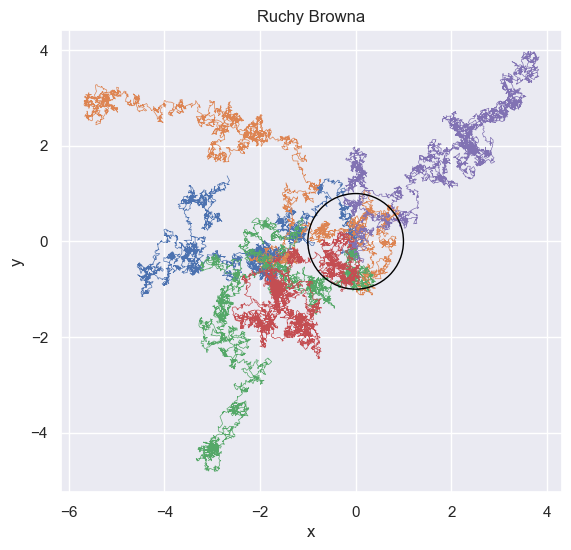

In [43]:
plot_brownian_motion(paths[:5])

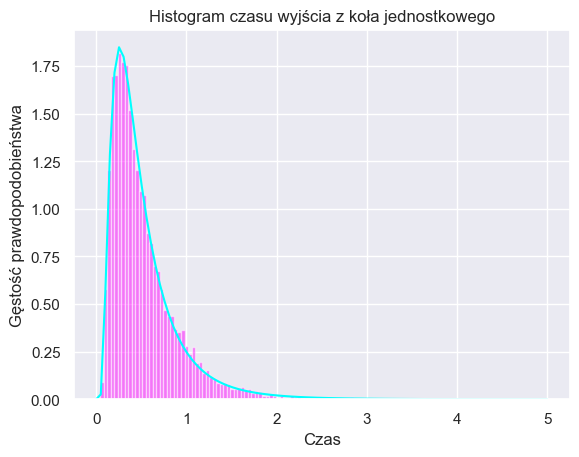

In [53]:
exit_times = [calculate_exit_time(path[0], path[1]) for path in paths]

s, loc, scale = stats.lognorm.fit(exit_times)

plt.hist(exit_times, bins=100, density=True, color='magenta', alpha=0.5)
density = stats.lognorm(s = s, loc = loc, scale = scale).pdf(np.linspace(0, 5, 100))
plt.plot(np.linspace(0, 5, 100), density, color='cyan')
plt.xlabel('Czas')
plt.ylabel('Gęstość prawdopodobieństwa')
plt.title('Histogram czasu wyjścia z koła jednostkowego')
plt.show()

Podejrzewamy, że czasy wyjścia pochodzą z rozkładu log-normalnego:

In [54]:
print(f'Parametry rozkładu log-normalnego: s = {s:.3f}, loc = {loc:.3f}, scale = {scale:.3f}')

Parametry rozkładu log-normalnego: s = 0.703, loc = 0.020, scale = 0.393


Sprawdzimy to testem statystycznym:

In [55]:
D, p = stats.kstest(exit_times, 'lognorm', args=(s, loc, scale))
print(f'Wartość statystyki D: {D:.3f}')
print(f'p-wartość: {p:.3f}')

Wartość statystyki D: 0.012
p-wartość: 0.103


$\text{p-wartość} > 0.05$, zatem nie mamy podstaw, by odrzucić hipotezę zerową.